In [1]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
from scipy.stats import linregress
import matplotlib.cm as cm
import matplotlib.colors as mcol
pd.set_option('display.max_rows', 5)

api_key = "cb3651d0"

In [2]:
#Reading in csv and previewing data
movie_data_df = pd.read_csv("imdb (1000 movies) in june 2022.csv")
movie_data_df.head()

,ranking of movie\r\n,movie name\r\n,Year,certificate,runtime,genre,RATING,metascore,DETAIL ABOUT MOVIE\n,DIRECTOR\r\n,ACTOR 1\n,ACTOR 2\n,ACTOR 3,ACTOR 4,votes,GROSS COLLECTION\r\n
0,1,The Shawshank Redemption,-1994,15,142 min,Drama,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,"2,603,314",$28.34M
1,2,The Godfather,-1972,X,175 min,"Crime, Drama",9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,"1,798,731",$134.97M
2,3,The Dark Knight,-2008,12A,152 min,"Action, Crime, Drama",9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,"2,574,810",$534.86M
3,4,The Lord of the Rings: The Return of the King,-2003,12A,201 min,"Action, Adventure, Drama",9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,"1,787,701",$377.85M
4,5,Schindler's List,-1993,15,195 min,"Biography, Drama, History",9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,"1,323,776",$96.90M


In [3]:
#renaming columns
clean_df = movie_data_df.rename(columns={
    "ranking of movie\r\n":"IMDB Rank",
    "movie name\r\n":"Movie Name",
    "certificate":"Rating",
    "runtime":"Runtime (Minutes)",
    "genre":"Genre",
    "RATING":"IMDB Score",
    "metascore":"Metascore",
    "DETAIL ABOUT MOVIE\n":"Details",
    "DIRECTOR\r\n":"Director",
    "ACTOR 1\n":"Actor 1",
    "ACTOR 2\n": "Actor 2",
    "ACTOR 3":"Actor 3",
    "ACTOR 4":"Actor 4",
    "votes":"IMDB Votes",
    "GROSS COLLECTION\r\n":"BoxOffice (Millions)"
})


#cleaning up columns and setting data types
#dropping null values
clean_df=clean_df.dropna()

# #cleaning year - removing "-" and setting to int

clean_df['Year'] = clean_df['Year'].str.extract(pat='(\d+)', expand=False)
clean_df["Year"]=clean_df["Year"].astype("int")

# #cleaning runtime and setting as int
clean_df["Runtime (Minutes)"]=clean_df["Runtime (Minutes)"].str.split(" ").str[0]
clean_df["Runtime (Minutes)"]=clean_df["Runtime (Minutes)"].astype("int")

# #clean up Genre to only get the first genre
clean_df["Main Genre"]=clean_df["Genre"].str.split(",").str[0]
clean_df["Sub Genre"]=clean_df["Genre"].str.split(",").str[1]
clean_df = clean_df.drop(columns="Genre")


#setting IMDB Score as int
clean_df["IMDB Score"]=clean_df["IMDB Score"].astype("float")

# #cleaning box office. Removing "$" and "M" and setting to float
clean_df["BoxOffice (Millions)"]=clean_df["BoxOffice (Millions)"].str.split("M").str[0]
clean_df["BoxOffice (Millions)"]=clean_df["BoxOffice (Millions)"].str.split("$").str[1]
clean_df["BoxOffice (Millions)"]=clean_df["BoxOffice (Millions)"].astype("float")

#Cleaning up IMDB votes and setting as int
clean_df["IMDB Votes"]=clean_df["IMDB Votes"].str.replace(",","")
clean_df["IMDB Votes"]=clean_df["IMDB Votes"].astype("int")


#standardize movie ratings
clean_df["Rating"]=clean_df["Rating"].replace("A","G")
clean_df["Rating"]=clean_df["Rating"].replace("U","G")
clean_df["Rating"]=clean_df["Rating"].replace("AA","PG")
clean_df["Rating"]=clean_df["Rating"].replace("12","PG")
clean_df["Rating"]=clean_df["Rating"].replace("15","PG-13")
clean_df["Rating"]=clean_df["Rating"].replace("12A","PG-13")
clean_df["Rating"]=clean_df["Rating"].replace("UA","PG-13")
clean_df["Rating"]=clean_df["Rating"].replace("18","R")
clean_df["Rating"]=clean_df["Rating"].replace("X","NC17")




#resetting index and displaying
clean_df=clean_df.reset_index()
clean_df=clean_df.drop(columns="index")
clean_df.head()

,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama
2,3,The Dark Knight,2008,PG-13,152,9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2574810,534.86,Action,Crime
3,4,The Lord of the Rings: The Return of the King,2003,PG-13,201,9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1787701,377.85,Action,Adventure
4,5,Schindler's List,1993,PG-13,195,9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1323776,96.90,Biography,Drama


In [4]:
#creating a new column to store award info
clean_df["Awards"]=""
clean_df

,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre,Awards
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN,
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,997,From Here to Eternity,1953,PG,118,7.6,85.0,"At a U.S. Army base in 1941 Hawaii, a private ...",Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,46804,30.50,Drama,Romance,
737,998,Snow White and the Seven Dwarfs,1937,G,83,7.6,95.0,Exiled into the dangerous forest by her wicked...,William Cottrell,David Hand,Wilfred Jackson,Larry Morey,Perce Pearce,196361,184.93,Animation,Adventure,


In [5]:
#search OMDB API for award info and put result in our new column

# for index, row in clean_df.iterrows():
#     try:
#         params = {
#         "apikey": api_key,
#         "t": row["Movie Name"]}
    
#         url = "http://www.omdbapi.com"
#         res = requests.get(url,params=params).json()
#         clean_df.loc[index,"Awards"]=res["Awards"]
#     except: 
#         pass
    

In [6]:
clean_df["Awards"]


0       
1       
      ..
736     
737     
Name: Awards, Length: 738, dtype: object

In [7]:
#put clean dataframe into csv
clean_df.to_csv("Refined_Data.csv",index=False)

In [8]:
#read clean csv to perform data analysis
refined_df=pd.read_csv("Refined_Data.csv")


In [9]:
clean_df["Rating"]=clean_df["Rating"].replace("U","G")
clean_df["Rating"]=clean_df["Rating"].replace("AA","PG")
clean_df["Rating"]=clean_df["Rating"].replace("12","PG")
clean_df["Rating"]=clean_df["Rating"].replace("15","PG-13")
clean_df["Rating"]=clean_df["Rating"].replace("12A","PG-13")
clean_df["Rating"]=clean_df["Rating"].replace("UA","PG-13")
clean_df["Rating"]=clean_df["Rating"].replace("18","R")
clean_df["Rating"]=clean_df["Rating"].replace("X","NC17")
clean_df

,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre,Awards
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN,
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,997,From Here to Eternity,1953,PG,118,7.6,85.0,"At a U.S. Army base in 1941 Hawaii, a private ...",Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,46804,30.50,Drama,Romance,
737,998,Snow White and the Seven Dwarfs,1937,G,83,7.6,95.0,Exiled into the dangerous forest by her wicked...,William Cottrell,David Hand,Wilfred Jackson,Larry Morey,Perce Pearce,196361,184.93,Animation,Adventure,


# Adriene K

# IMdb Score vs BoxOffice (not used in presentation)
### Does the IMbd Score of a movie affect how much money it generates?

/var/folders/23/l3b1_qsd0ydfx9g3yyv96wrr0000gn/T/ipykernel_47003/546437622.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ak_df_mean = clean_df.groupby('Main Genre').mean()
/var/folders/23/l3b1_qsd0ydfx9g3yyv96wrr0000gn/T/ipykernel_47003/546437622.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ak_df_ = clean_df.groupby('Main Genre').mean()


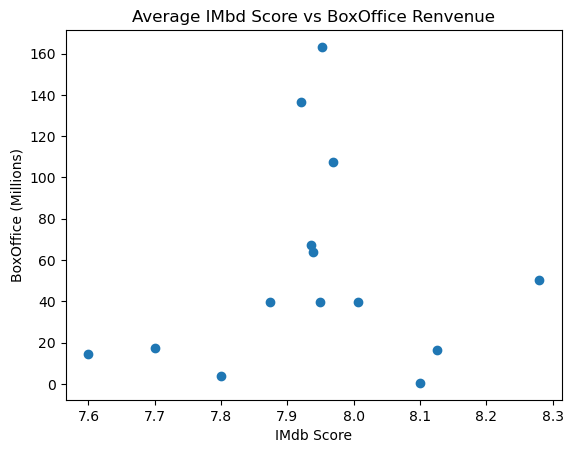

In [10]:
ak_df_mean = clean_df.groupby('Main Genre').mean()
ak_df_ = clean_df.groupby('Main Genre').mean()

ak_df_mean=ak_df_mean.reset_index()

x_axis1 = ak_df_mean['IMDB Score']
y_axis1 = ak_df_mean['BoxOffice (Millions)']

plt.xlabel('IMdb Score')
plt.ylabel('BoxOffice (Millions)')
plt.title('Average IMbd Score vs BoxOffice Renvenue')

plt.scatter(x_axis1, y_axis1)
plt.show()

# Audience Rating vs Box Office
### Does the audience rating affect the amount of money a movie makes?

/var/folders/23/l3b1_qsd0ydfx9g3yyv96wrr0000gn/T/ipykernel_47003/1149226190.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rating_df_mean = clean_df.groupby('Rating').mean()


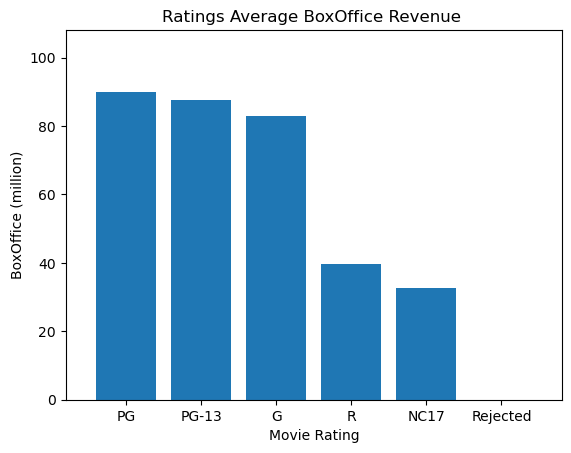

In [11]:
rating_df_mean = clean_df.groupby('Rating').mean()

rating_df_mean = rating_df_mean.sort_values(by = 'BoxOffice (Millions)',ascending = False)

rating_df_mean=rating_df_mean.reset_index()

x_axis1 = rating_df_mean ['Rating']
y_axis1 = rating_df_mean ['BoxOffice (Millions)']
labels = clean_df['Movie Name']
plt.bar(x_axis1, y_axis1)
plt.margins(0.07,0.2)
plt.xlabel('Movie Rating')
plt.ylabel('BoxOffice (million)')
plt.title('Ratings Average BoxOffice Revenue ')

plt.savefig('Graphs/Ratings_Revenue.png')
plt.show()

# Genre # of apperances on Top 1000 list (not used in presentation)
### What is the most popular genre of movies?

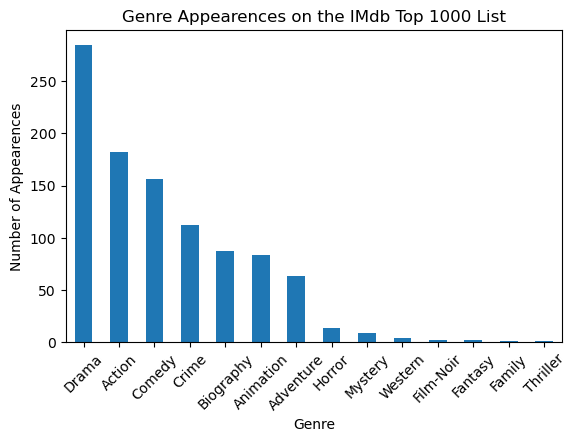

In [12]:

app_df = movie_data_df.rename(columns={
    "ranking of movie\r\n":"IMDB Rank",
    "movie name\r\n":"Movie Name",
    "certificate":"Rating",
    "runtime":"Runtime (Minutes)",
    "genre":"Genre",
    "RATING":"IMDB Score",
    "metascore":"Metascore",
    "DETAIL ABOUT MOVIE\n":"Details",
    "DIRECTOR\r\n":"Director",
    "ACTOR 1\n":"Actor 1",
    "ACTOR 2\n": "Actor 2",
    "ACTOR 3":"Actor 3",
    "ACTOR 4":"Actor 4",
    "votes":"IMDB Votes",
    "GROSS COLLECTION\r\n":"BoxOffice (Millions)"
})

# #clean up Genre to only get the first genre
app_df["Main Genre"]=app_df["Genre"].str.split(",").str[0]
app_df["Sub Genre"]=app_df["Genre"].str.split(",").str[1]
app_df = app_df.drop(columns="Genre")


num_app= app_df['Main Genre'].value_counts()

num_app.plot(kind='bar')

plt.title('Genre Appearences on the IMdb Top 1000 List')
plt.xlabel('Genre')
plt.ylabel('Number of Appearences')
plt.xticks(rotation = 45)
plt.subplots_adjust(bottom=0.230)
plt.savefig('Graphs/Genre_Appearences.png')
plt.show()

# Top 5 Rated Actors
### By IMDB score

In [13]:
Actor1_df= clean_df.groupby('Actor 1').mean()['IMDB Score']

/var/folders/23/l3b1_qsd0ydfx9g3yyv96wrr0000gn/T/ipykernel_47003/493494598.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Actor1_df= clean_df.groupby('Actor 1').mean()['IMDB Score']


In [14]:
top5 = Actor1_df.sort_values(ascending = False).head(5)

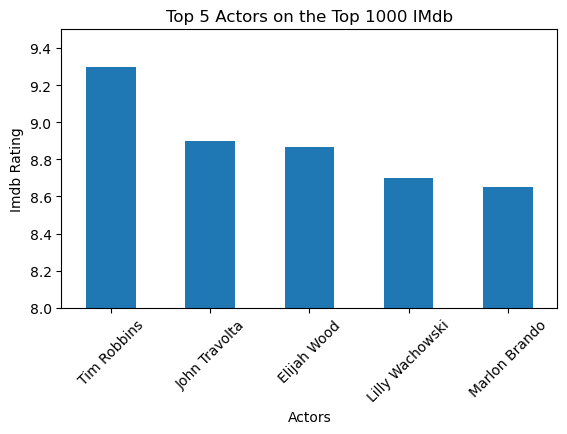

In [15]:
top5.plot(kind = 'bar')
plt.ylim(8,9.5)

plt.title('Top 5 Actors on the Top 1000 IMdb')
plt.xlabel('Actors')
plt.ylabel('Imdb Rating')
plt.xticks(rotation = 45)

plt.subplots_adjust(bottom=0.30)
plt.savefig('Graphs/Top_5_Actor_byscore.png')
plt.show()

### By # of appearences

In [16]:
Actor2_df = clean_df['Actor 1'].value_counts()
Actor2_df = Actor2_df.head(5)

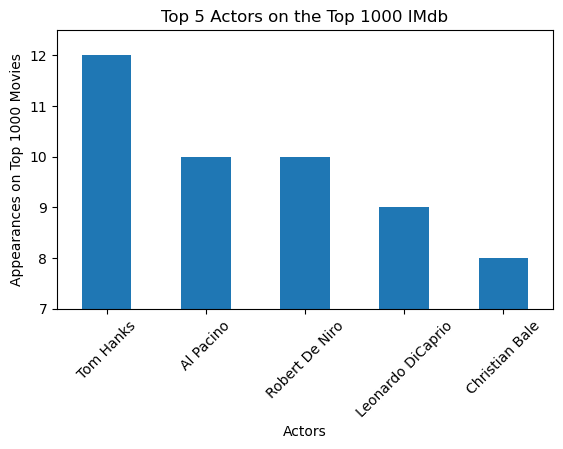

In [17]:
Actor2_df.plot(kind='bar')
plt.ylim(7,12.5)
plt.title('Top 5 Actors on the Top 1000 IMdb')
plt.xlabel('Actors')
plt.ylabel('Appearances on Top 1000 Movies')
plt.xticks(rotation = 45)

plt.subplots_adjust(bottom=0.30)
plt.savefig('Graphs/Top_5_Actor.png')
plt.show()

# Year vs lengths
### How is the lengths of popular movies changed over the years? (V1 not used)

In [18]:
year_df = app_df
year_df['Year'] = app_df['Year'].str.extract(pat='(\d+)', expand=False)
year_df["Year"]=year_df["Year"].astype("int")

In [19]:
data = {
    'IMDB Rank': year_df['IMDB Rank'],
    'Movie Name':year_df['Movie Name'],
    'Year':year_df['Year'],
    'Runtime (Minutes)': clean_df['Runtime (Minutes)']
    }
timeline_df=pd.DataFrame(data= data)

In [20]:
bins = [1900,1929,1959,1989,2019,2059]
labels = ['1900-1929','1930-1959','1960-1989','1990-2019','2020+']
timeline_df['bin'] = pd.cut(timeline_df['Year'],bins, labels = labels,include_lowest=True)
timeline_df

,IMDB Rank,Movie Name,Year,Runtime (Minutes),bin
0,1,The Shawshank Redemption,1994,142.0,1990-2019
1,2,The Godfather,1972,175.0,1960-1989
...,...,...,...,...,...
998,999,The 39 Steps,1935,NaN,1930-1959
999,"1,000.00",The Invisible Man,1933,NaN,1930-1959


In [21]:
timeline_df_group=timeline_df.groupby(timeline_df['bin']).mean()

/var/folders/23/l3b1_qsd0ydfx9g3yyv96wrr0000gn/T/ipykernel_47003/238310547.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  timeline_df_group=timeline_df.groupby(timeline_df['bin']).mean()


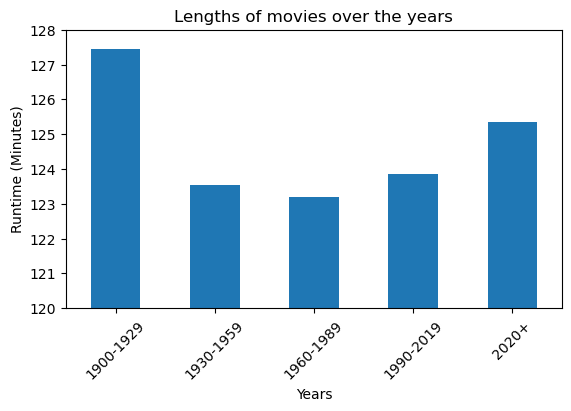

In [22]:
timeline_df_group['Runtime (Minutes)'].plot(kind='bar')
plt.ylim(120, 128)
plt.title('Lengths of movies over the years')
plt.xlabel('Years')
plt.ylabel('Runtime (Minutes)')
plt.xticks(rotation = 45)

plt.subplots_adjust(bottom=0.30)
plt.savefig('Graphs/Runtime_Over_years.png')
plt.show()


### (V2) used

In [23]:
df_1920s=[]
df_1930s=[]
df_1940s=[]
df_1950s=[]
df_1960s=[]
df_1970s=[]
df_1980s=[]
df_1990s=[]
df_2000s=[]
df_2010s=[]
df_2020s=[]

mean_BO_per_decade=[]
mean_awd_by_decade=[]


for index, row in timeline_df.iterrows():
    if row["Year"]<1930:
        df_1920s.append(row)
        decade_1920=pd.DataFrame(df_1920s)
        
    elif (row["Year"]>=1930) & (row["Year"]<1940):
        df_1930s.append(row)
        decade_1930=pd.DataFrame(df_1930s)
    
    elif (row["Year"]>=1940) & (row["Year"]<1950):
        df_1940s.append(row)
        decade_1940=pd.DataFrame(df_1940s)
       
    elif (row["Year"]>=1950) & (row["Year"]<1960):
        df_1950s.append(row)
        decade_1950=pd.DataFrame(df_1950s)
        
    elif (row["Year"]>=1960) & (row["Year"]<1970):
        df_1960s.append(row)
        decade_1960=pd.DataFrame(df_1960s)
        
    elif (row["Year"]>=1970) & (row["Year"]<1980):
        df_1970s.append(row)
        decade_1970=pd.DataFrame(df_1970s)
    
    elif (row["Year"]>=1980) & (row["Year"]<1990):
        df_1980s.append(row)
        decade_1980=pd.DataFrame(df_1980s)
      
       
    elif (row["Year"]>=1990) & (row["Year"]<2000): 
        df_1990s.append(row)
        decade_1990=pd.DataFrame(df_1990s)
        
    elif (row["Year"]>=2000) & (row["Year"]<2010):
        df_2000s.append(row)
        decade_2000=pd.DataFrame(df_2000s)
        
    elif (row["Year"]>=2010) & (row["Year"]<2020):
        df_2010s.append(row)
        decade_2010=pd.DataFrame(df_2010s)
    
    elif (row["Year"]>=2020) & (row["Year"]<2030):
        df_2020s.append(row)
        decade_2020=pd.DataFrame(df_2020s)

In [24]:
mean_1920=decade_1920["Runtime (Minutes)"].mean()
mean_1930=decade_1930["Runtime (Minutes)"].mean()
mean_1940=decade_1940["Runtime (Minutes)"].mean()
mean_1950=decade_1950["Runtime (Minutes)"].mean()
mean_1960=decade_1960["Runtime (Minutes)"].mean()
mean_1970=decade_1970["Runtime (Minutes)"].mean()
mean_1980=decade_1980["Runtime (Minutes)"].mean()
mean_1990=decade_1990["Runtime (Minutes)"].mean()
mean_2000=decade_2000["Runtime (Minutes)"].mean()
mean_2010=decade_2010["Runtime (Minutes)"].mean()
mean_2020=decade_2020["Runtime (Minutes)"].mean()
#creating a list of average box office earnings
mean_rt_per_decade=[mean_1920,mean_1930,mean_1940,mean_1950,mean_1960,mean_1970,mean_1980,mean_1990,mean_2000,mean_2010,mean_2020]



In [25]:
mean_1940

119.08333333333333

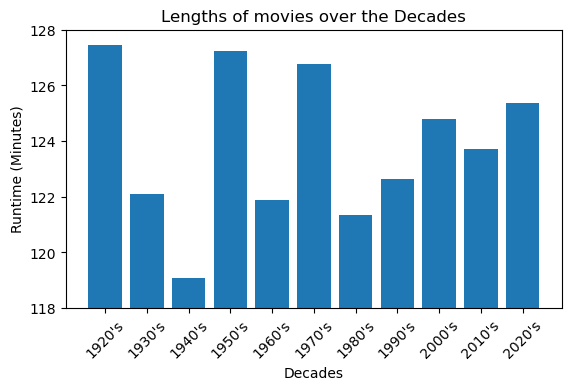

In [26]:
decades=["1920's","1930's","1940's","1950's","1960's","1970's","1980's","1990's","2000's","2010's","2020's"]

plt.bar(decades,mean_rt_per_decade)
plt.ylim(118, 128)
plt.title('Lengths of movies over the Decades')
plt.xlabel('Decades')
plt.ylabel('Runtime (Minutes)')
plt.xticks(rotation = 45)

plt.subplots_adjust(bottom=0.30)
plt.savefig('Graphs/Runtime_Over_Decades.png')
plt.show()

# Delilah 

# Dalila  Genre vs Gross ,Does the genre of the movie dictate the gross at boxoffice?

In [27]:
clean_df ["Main Genre"]
clean_df["BoxOffice (Millions)"]

0       28.34
1      134.97
        ...  
736     30.50
737    184.93
Name: BoxOffice (Millions), Length: 738, dtype: float64

In [28]:
clean_df ["Main Genre"].value_counts()


Drama       206
Action      133
           ... 
Thriller      1
Fantasy       1
Name: Main Genre, Length: 14, dtype: int64

In [29]:
bygenre_df = clean_df.groupby("Main Genre").mean()

/var/folders/23/l3b1_qsd0ydfx9g3yyv96wrr0000gn/T/ipykernel_47003/2668179842.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bygenre_df = clean_df.groupby("Main Genre").mean()


In [30]:
bygenre_df 

,Year,Runtime (Minutes),IMDB Score,Metascore,IMDB Votes,BoxOffice (Millions)
Main Genre,,,,,,
Action,2000.263158,128.473684,7.951880,74.338346,610258.368421,163.267068
Adventure,1988.775510,135.102041,7.969388,79.122449,453367.367347,107.517959
...,...,...,...,...,...,...
Thriller,1967.000000,108.000000,7.700000,81.000000,30454.000000,17.550000
Western,1967.000000,143.250000,8.125000,79.000000,178020.500000,16.165000


In [31]:
bygenre_df = bygenre_df.reset_index()

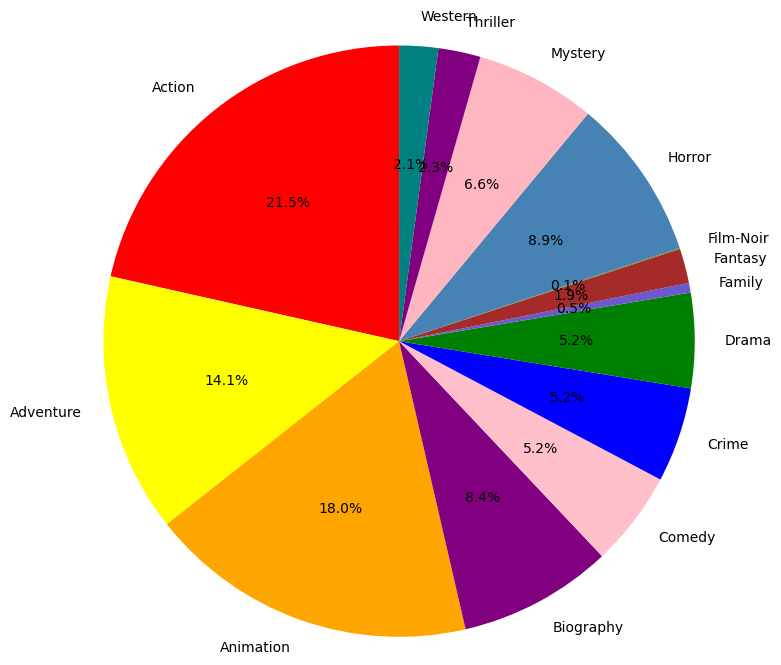

In [32]:

import matplotlib.pyplot as plt

labels= bygenre_df['Main Genre']

sizes = bygenre_df['BoxOffice (Millions)']
colors = ['red', 'yellow', 'orange', 'purple', 'pink','blue','green','Slateblue','brown','olive','steelblue','lightpink','purple','teal']


# Create pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,radius=2)

# Show plot
plt.show()


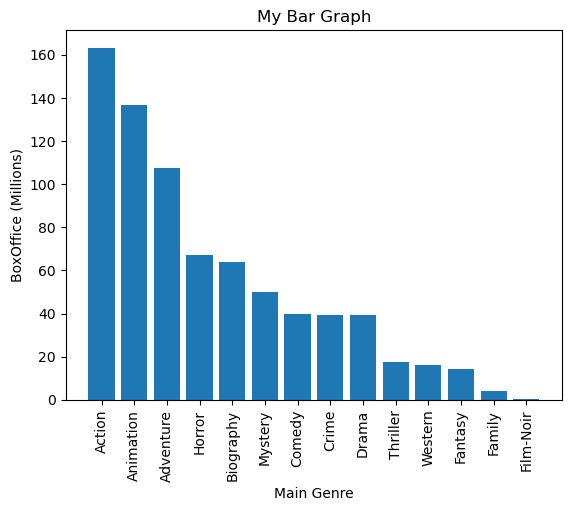

In [33]:
import numpy as np
import matplotlib.pyplot as plt

 
x = ['Action','Animation','Adventure','Horror','Biography','Mystery','Comedy','Crime','Drama','Thriller','Western','Fantasy','Family','Film-Noir']
y = [163.267068,136.756364,107.517959,67.360000,64.086429,50.130000,39.586355,39.472289,39.436019,17.550000,16.165000,14.380000,4.000000,0.450000]

# Create bar graph
plt.bar(x, y)


# Add labels and title
plt.xlabel('Main Genre')
plt.ylabel('BoxOffice (Millions)')
plt.title('My Bar Graph')



plt.xticks(rotation = 'vertical') 
# Show graph
plt.show()


# David C

In [34]:
#creating a new column to store award info
clean_df["Awards"]=""
clean_df.head()

,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre,Awards
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN,
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama,
2,3,The Dark Knight,2008,PG-13,152,9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2574810,534.86,Action,Crime,
3,4,The Lord of the Rings: The Return of the King,2003,PG-13,201,9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1787701,377.85,Action,Adventure,
4,5,Schindler's List,1993,PG-13,195,9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1323776,96.90,Biography,Drama,


In [35]:
#search OMDB API for award info and put result in our new column

# for index, row in clean_df.iterrows():
#     try:
#         params = {
#         "apikey": api_key,
#         "t": row["Movie Name"]}
    
#         url = "http://www.omdbapi.com"
#         res = requests.get(url,params=params).json()
#         clean_df.loc[index,"Awards"]=res["Awards"]
#     except: 
#         pass
# clean_df.head()

SyntaxError: invalid syntax (3754261328.py, line 1)

In [ ]:

#  clean_df.to_csv("Refined_Data.csv",index=False)

In [ ]:
test_df= pd.read_csv("Final_Data.csv")
test_df.head()


In [ ]:
# test_df["Total Awards & Nominations"] = 0

In [ ]:

for index, row in test_df.iterrows():
    try:
        tot_awards=re.findall(r'\d+', row["Awards"])
        test_df.loc[index,"Total Awards & Nominations"]= sum(map(int, tot_awards))
    except:
        pass
        
        
        
        





In [ ]:
test_df.head()

In [ ]:
# test_df.to_csv("Final_Data.csv",index=False)

# Does the amount of awards impact box office earnings?

In [ ]:
# Visualizations

#initializing x and y values
x=test_df["Total Awards & Nominations"]
y=test_df["BoxOffice (Millions)"]
slope, intercept, r, p, std_err = linregress(x,y)

#calculating regression line
def slopefunc(x):
    return (slope * x) + intercept
reg_line=slopefunc(x)

#plotting regression line
plt.plot(x,reg_line,color="red")

plt.scatter(x,y,alpha=.45,c=y,cmap="rainbow", s=y)
plt.title("Awards Wins & Nominations VS Box Office")
plt.ylabel("BoxOffice (Millions)")
plt.xlabel("Awards Wins & Nominations")
plt.text(400, 400, f'Y = {round(slope,3)}x+{round(intercept,3)}', fontsize = 10, color = "r")
plt.text(-155, 35, "Regression Line",fontsize = 7, color = "r")
plt.xticks((np.arange(0, max(x)+1, 25.0)))
plt.xticks(rotation='vertical')
plt.savefig("Fig_Awards Wins & Nominations VS Box Office")
plt.colorbar()
plt.show()



In [ ]:
#We can see the correlation between award wins and nominations and boxoffice is 0.271396.
#This means there is NOT a strong relationship between box office amount and award wins and nominations
test_df.corr()



In [ ]:
#iterating through dateframe to pull movies into specific lists based on when they were made

df_1920s=[]
df_1930s=[]
df_1940s=[]
df_1950s=[]
df_1960s=[]
df_1970s=[]
df_1980s=[]
df_1990s=[]
df_2000s=[]
df_2010s=[]
df_2020s=[]

mean_BO_per_decade=[]
mean_awd_by_decade=[]


for index, row in test_df.iterrows():
    if row["Year"]<1930:
        df_1920s.append(row)
        decade_1920=pd.DataFrame(df_1920s)
        
    elif (row["Year"]>=1930) & (row["Year"]<1940):
        df_1930s.append(row)
        decade_1930=pd.DataFrame(df_1930s)
    
    elif (row["Year"]>=1940) & (row["Year"]<1950):
        df_1940s.append(row)
        decade_1940=pd.DataFrame(df_1940s)
       
    elif (row["Year"]>=1950) & (row["Year"]<1960):
        df_1950s.append(row)
        decade_1950=pd.DataFrame(df_1950s)
        
    elif (row["Year"]>=1960) & (row["Year"]<1970):
        df_1960s.append(row)
        decade_1960=pd.DataFrame(df_1960s)
        
    elif (row["Year"]>=1970) & (row["Year"]<1980):
        df_1970s.append(row)
        decade_1970=pd.DataFrame(df_1970s)
    
    elif (row["Year"]>=1980) & (row["Year"]<1990):
        df_1980s.append(row)
        decade_1980=pd.DataFrame(df_1980s)
      
       
    elif (row["Year"]>=1990) & (row["Year"]<2000): 
        df_1990s.append(row)
        decade_1990=pd.DataFrame(df_1990s)
        
    elif (row["Year"]>=2000) & (row["Year"]<2010):
        df_2000s.append(row)
        decade_2000=pd.DataFrame(df_2000s)
        
    elif (row["Year"]>=2010) & (row["Year"]<2020):
        df_2010s.append(row)
        decade_2010=pd.DataFrame(df_2010s)
    
    elif (row["Year"]>=2020) & (row["Year"]<2030):
        df_2020s.append(row)
        decade_2020=pd.DataFrame(df_2020s)


In [ ]:
#calculating mean boxoffice earnings per decade and putting them into a list
mean_1920=decade_1920["BoxOffice (Millions)"].mean()
mean_1930=decade_1930["BoxOffice (Millions)"].mean()
mean_1940=decade_1940["BoxOffice (Millions)"].mean()
mean_1950=decade_1950["BoxOffice (Millions)"].mean()
mean_1960=decade_1960["BoxOffice (Millions)"].mean()
mean_1970=decade_1970["BoxOffice (Millions)"].mean()
mean_1980=decade_1980["BoxOffice (Millions)"].mean()
mean_1990=decade_1990["BoxOffice (Millions)"].mean()
mean_2000=decade_2000["BoxOffice (Millions)"].mean()
mean_2010=decade_2010["BoxOffice (Millions)"].mean()
mean_2020=decade_2020["BoxOffice (Millions)"].mean()
#creating a list of average box office earnings
mean_BO_per_decade=[mean_1920,mean_1930,mean_1940,mean_1950,mean_1960,mean_1970,mean_1980,mean_1990,mean_2000,mean_2010,mean_2020]

#calculating average awards per decade
meanawd_1920=decade_1920["Total Awards & Nominations"].mean()
meanawd_1930=decade_1930["Total Awards & Nominations"].mean()
meanawd_1940=decade_1940["Total Awards & Nominations"].mean()
meanawd_1950=decade_1950["Total Awards & Nominations"].mean()
meanawd_1960=decade_1960["Total Awards & Nominations"].mean()
meanawd_1970=decade_1970["Total Awards & Nominations"].mean()
meanawd_1980=decade_1980["Total Awards & Nominations"].mean()
meanawd_1990=decade_1990["Total Awards & Nominations"].mean()
meanawd_2000=decade_2000["Total Awards & Nominations"].mean()
meanawd_2010=decade_2010["Total Awards & Nominations"].mean()
meanawd_2020=decade_2020["Total Awards & Nominations"].mean()
#creating a list of average awards
mean_awd_by_decade=[meanawd_1920,meanawd_1930,meanawd_1940,meanawd_1950,meanawd_1960,meanawd_1970,meanawd_1980,meanawd_1990,meanawd_2000,meanawd_2010,meanawd_2020]


In [ ]:
#plotting box office and award averages over time
decades=["1920's","1930's","1940's","1950's","1960's","1970's","1980's","1990's","2000's","2010's","2020's"]

plt.scatter(decades,mean_BO_per_decade,s=mean_BO_per_decade,label="Average Box Office Earnings")
plt.scatter(decades,mean_awd_by_decade,s=mean_BO_per_decade,label="Average Number of Awards")
plt.xticks(rotation='vertical')  
plt.ylabel("Number of Awards and Box Office Gross")
plt.xlabel("Decade")
plt.title("Average Box Office Earnings & Awards Over Time")
plt.savefig("Fig_Average Box Office Earnings & Awards Over Time")
plt.legend(loc="upper left")

In [ ]:
#Analysis: In the 1960’s you were most likely to have higher box office earnings the more awards you had (based off correlation of box office and total awards nad noms.

In [ ]:
#creating a histogram
mean_bo=test_df["BoxOffice (Millions)"].mean()
mean_b0x=np.array([1930,1935,1940,1945,1950,1955,1960,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020])
mean_b0xy= np.array([77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53])

fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(x, bins=11, color="green")
plt.title("Movie Award Count")
plt.ylabel("Number of Movies")
plt.xlabel("Number of Awards Wins & Nominations")
plt.xticks((np.arange(0, max(x)+1, 50.0)))
plt.text(125, 200, "A majority of films have less than 100 awards",fontsize = 8, color = "r")
plt.text(300, 125, "Average=78.6",fontsize = 8, color = "r")

decades=test_df.groupby(["Year"]).count()

plt.subplot(1,2,2)
x1=test_df["Year"]
y1=test_df["BoxOffice (Millions)"]
size=test_df["Total Awards & Nominations"]
plt.xticks((np.arange(1930, max(x1)+1, 5.0)))
plt.title("Box Office & Awards by Year")
plt.ylabel("Box Office (Millions)")
plt.xlabel("Year")
plt.xticks(rotation='vertical')  
plt.scatter(x1,y1,s=size,alpha=.2)
plt.plot(mean_b0x,mean_b0xy, color="red")
plt.text(2028, 80, "Average = 77.53",fontsize = 8, color = "r")
plt.savefig("Fig_3")
plt.suptitle('Box Office Vs Amount of Awards')

